In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [3]:
from nlinec.data.load import get_positive_data, get_all_types
from nlinec.data.preprocessing import get_granularity
from nlinec.utils import get_results_dir

In [4]:
DATASET = 'augmented_train.json'

In [5]:
data = get_positive_data(DATASET)
data

793487it [00:14, 55293.43it/s] 


,full_type,mention_span,sentence
0,[/other],the history and science of aviation and spacef...,"Located in Washington, D.C., United States, it..."
1,[/other],his debut,"The seventh child of the Jackson family, he ma..."
2,"[/location/country, /location]",We,We did not do anything at that time.
3,"[/other, /other/scientific]",antibody,`` We don't know the effect of our antibody on...
4,"[/location/city, /location]",Lisbon,The Visigoths of Spain were defeated when the ...
...,...,...,...
793482,"[/other/event/sports_event, /other, /other/event]",The game,"The game features 25 songs by Van Halen, 3 gu..."
793483,"[/other, /other/health/treatment, /other/health]",transfer,It marked the first peaceful transfer of power...
793484,"[/location/country, /location, /location/struc...",American,"Right now, the American populace is spending a..."
793485,"[/other/art/film, /other, /other/art]",his films,"As a boy, he donated his Bar Mitzvah money to ..."


## Type Distribution

In [6]:
data['n_types'] = data['full_type'].apply(lambda x: len(x))

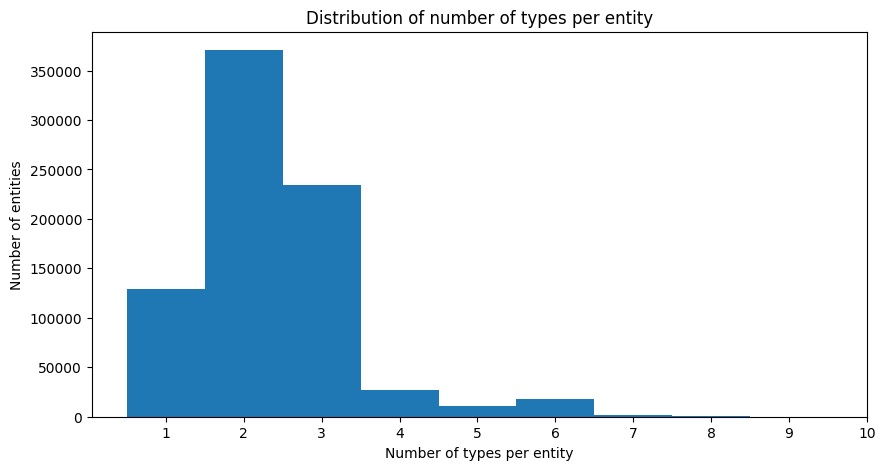

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(data['n_types'], bins=range(1, max(data['n_types'])))
ax.set_xlabel('Number of types per entity')
ax.set_ylabel('Number of entities')
ax.set_title('Distribution of number of types per entity');
ax.set_xticks(np.arange(1, max(data['n_types'])) + 0.5)
ax.set_xticklabels(np.arange(1, max(data['n_types'])));

In [8]:
# Explode the types
types = data['full_type'].explode().reset_index(drop=True)

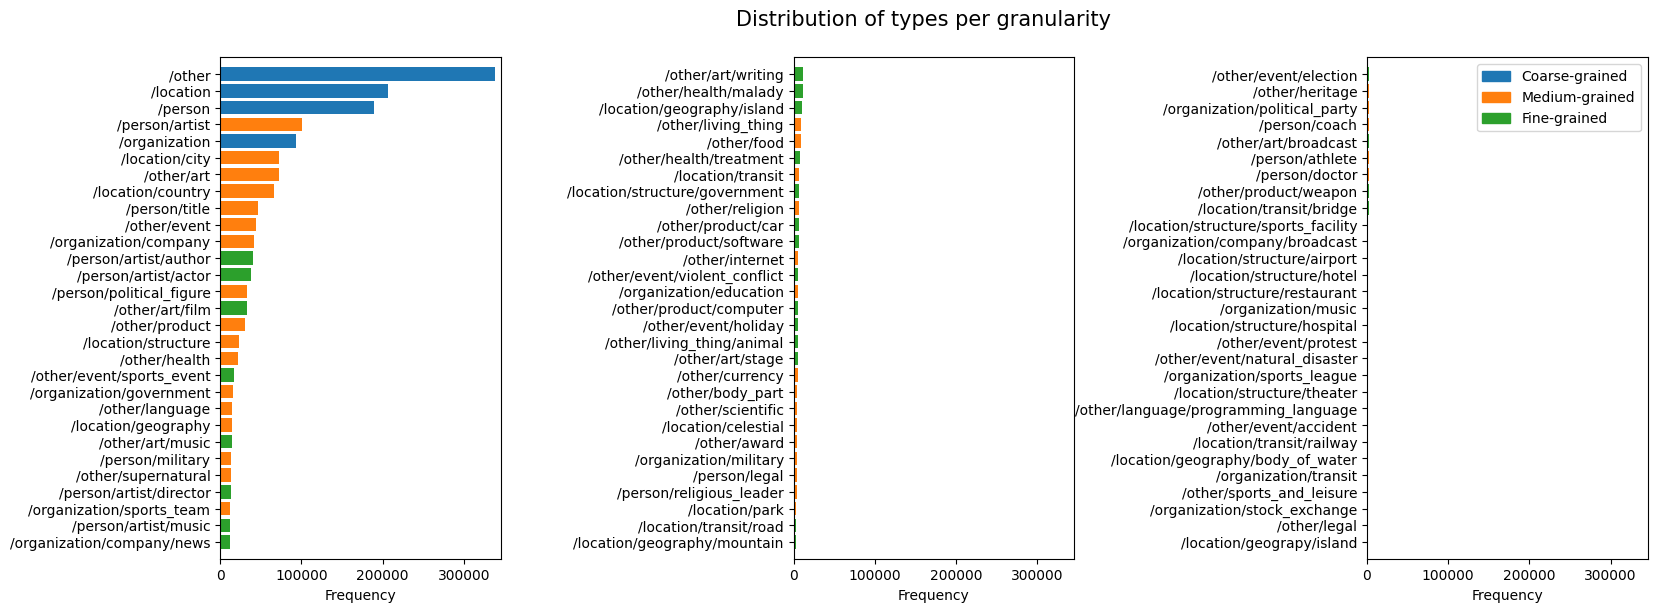

In [9]:
type_counts = types.value_counts()
granularity_colors = ['tab:blue', 'tab:orange', 'tab:green']
granularity_labels = ['Coarse-grained', 'Medium-grained', 'Fine-grained']

# Split the plot over multiple columns
N_COLS = 3
type_per_col = len(type_counts) // N_COLS

fig, axes = plt.subplots(1, N_COLS, figsize=(5 * N_COLS, 20 // N_COLS))
fig.tight_layout(w_pad=18)
fig.suptitle('Distribution of types per granularity', fontsize=15)
fig.subplots_adjust(top=0.9)

for a, ax in enumerate(axes):
    start = a * type_per_col
    end = (a + 1) * type_per_col
    for i, (type, count) in enumerate(type_counts[start:end].items()):
        ax.barh(len(type_counts[start:end]) - i, count, color=granularity_colors[get_granularity(type) - 1])
    ax.set_yticks(np.arange(1, len(type_counts[start:end]) + 1))
    ax.set_yticklabels(type_counts[start:end].index[::-1])
    ax.set_ylim(0, len(type_counts[start:end]) + 1)
    ax.set_xlim(0, max(type_counts) * 1.02)
    ax.set_xlabel('Frequency')

# Add a legend
granularity_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in granularity_colors]
axes[-1].legend(granularity_handles, granularity_labels, loc='upper right');

## Entity distribution

In [10]:
entity_counts = data['mention_span'].value_counts()
len(entity_counts)

212886

In [11]:
# Find the most ambiguous entities
ambiguity_index = {}
for i, row in tqdm(data.iterrows(), total=len(data)):
    for full_type in row['full_type']:
        # If the entity is not in the index, add an empty dict for its types
        if row['mention_span'] not in ambiguity_index:
            ambiguity_index[row['mention_span']] = {}

        # If the entity type is not in the index, add an empty count
        if full_type not in ambiguity_index[row['mention_span']]:
            ambiguity_index[row['mention_span']][full_type] = 0

        # Increment the count
        ambiguity_index[row['mention_span']][full_type] += 1

100%|██████████| 793487/793487 [00:16<00:00, 48693.53it/s]


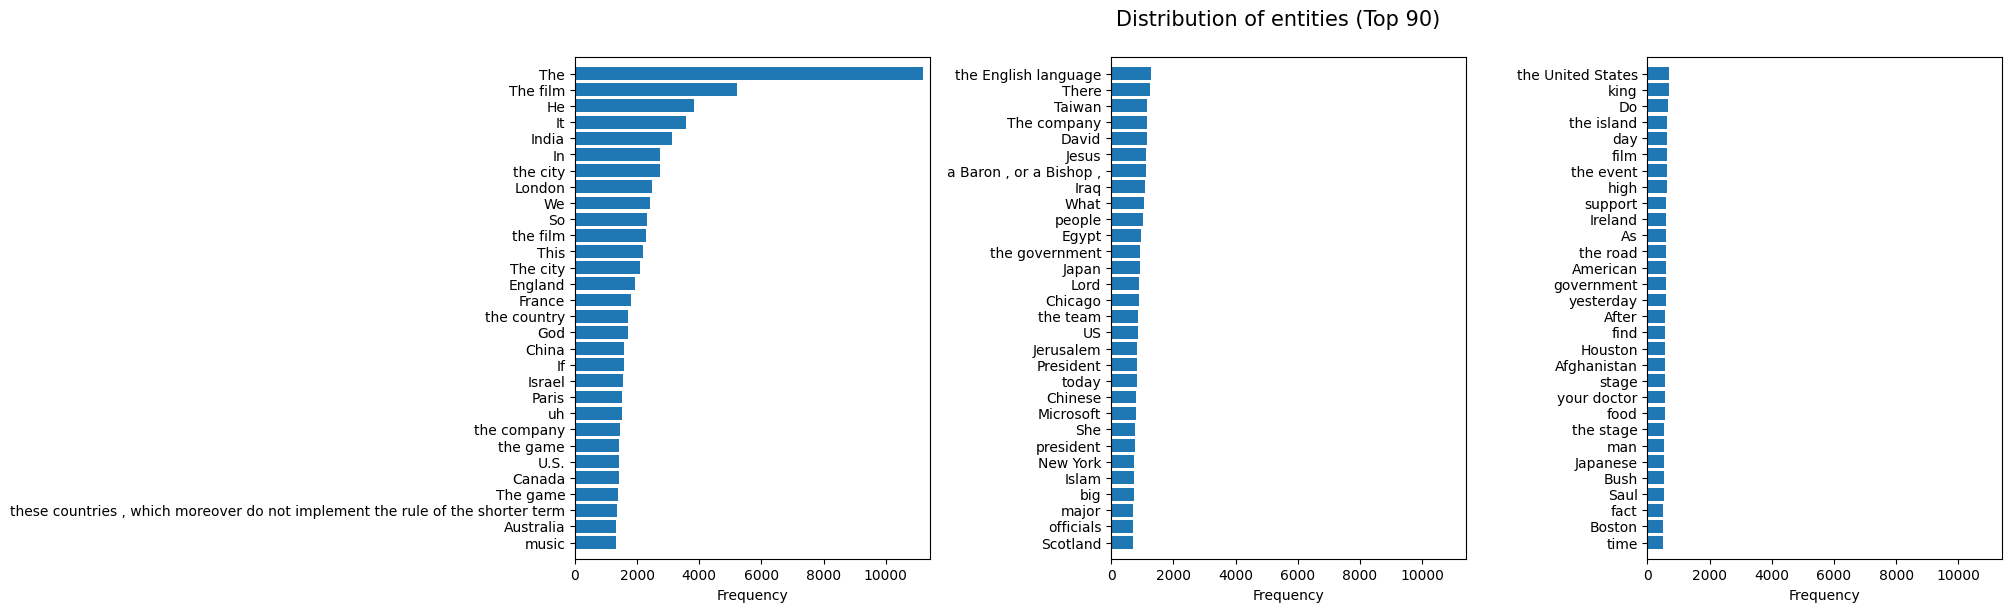

In [12]:
top_entity_counts = entity_counts[:90]

# Split the plot over multiple columns
N_COLS = 3
entity_per_col = len(top_entity_counts) // N_COLS

fig, axes = plt.subplots(1, N_COLS, figsize=(5 * N_COLS, 20 // N_COLS))
fig.tight_layout(w_pad=10)
fig.suptitle('Distribution of entities (Top 90)', fontsize=15)
fig.subplots_adjust(top=0.9)

for a, ax in enumerate(axes):
    start = a * entity_per_col
    end = (a + 1) * entity_per_col
    for i, (type, count) in enumerate(top_entity_counts[start:end].items()):
        ax.barh(len(top_entity_counts[start:end]) - i, count, color='tab:blue')
    ax.set_yticks(np.arange(1, len(top_entity_counts[start:end]) + 1))
    ax.set_yticklabels(top_entity_counts[start:end].index[::-1])
    ax.set_ylim(0, len(top_entity_counts[start:end]) + 1)
    ax.set_xlim(0, max(top_entity_counts) * 1.02)
    ax.set_xlabel('Frequency')

In [18]:
# Convert the ambiguity index to a dataframe
ambiguity_df = pd.DataFrame(ambiguity_index).T

# Sort the rows by the total number of types
ambiguity_df['total'] = ambiguity_df.sum(axis=1)
ambiguity_df = ambiguity_df.sort_values(by='total', ascending=False)

In [34]:
top_n_entities = 16

In [35]:
# Only keep the types that occur at all in the top top_n_entities entities
relevant_types = ambiguity_df.iloc[:top_n_entities].dropna(axis=1, how='all').columns

# Remove the total column
relevant_types = relevant_types[:-1]

In [36]:
top_amiguity_df = ambiguity_df[relevant_types][:top_n_entities]

In [37]:
# Sort the columns alphabetically
top_amiguity_df = top_amiguity_df[sorted(top_amiguity_df.columns)]

In [38]:
top_amiguity_df

,/location,/location/city,/location/country,/location/structure,/location/structure/government,/organization,/organization/company,/organization/company/news,/organization/government,/organization/military,...,/person,/person/artist,/person/artist/actor,/person/artist/author,/person/artist/director,/person/athlete,/person/military,/person/political_figure,/person/religious_leader,/person/title
The,NaN,NaN,NaN,NaN,NaN,2615.0,2615.0,2615.0,NaN,NaN,...,8553.0,8553.0,8553.0,8553.0,NaN,NaN,8553.0,8553.0,NaN,NaN
The film,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
He,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3715.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,3712.0
It,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
the film,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
God,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1567.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1567.0
India,3113.0,115.0,2998.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
David,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1147.0,1144.0,NaN,1141.0,2.0,NaN,NaN,1144.0,1141.0,NaN
In,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
the city,2726.0,2726.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


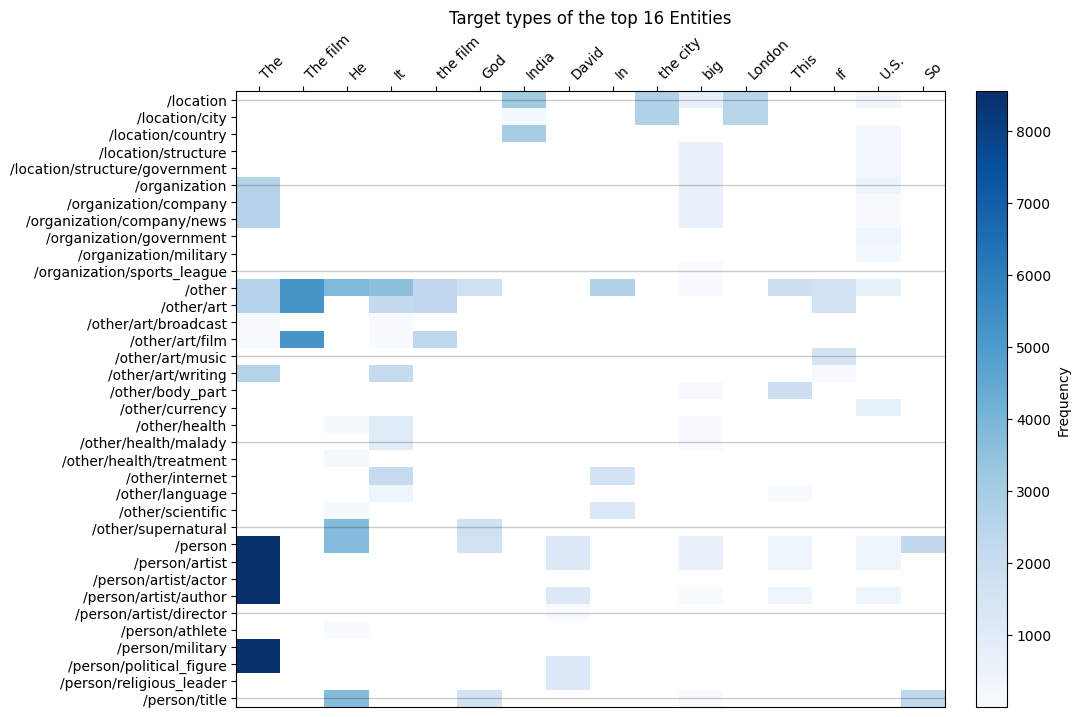

In [41]:
# Shot a 2D heatmap of the ambiguity index for the top top_n_entities entities
fig, ax = plt.subplots(figsize=(10, 8))
img = ax.imshow(top_amiguity_df.T.values, cmap='Blues', aspect='auto')
ax.set_yticks(np.arange(len(top_amiguity_df.columns)))
ax.set_yticklabels(top_amiguity_df.columns)
ax.set_xticks(np.arange(top_n_entities))
ax.set_xticklabels(top_amiguity_df.index[:top_n_entities], rotation=45, ha='left')
for i in range(0, len(top_amiguity_df.columns), 5):
    ax.axhline(i, color='black', linewidth=1, alpha=0.2)

# Show the x axis on top
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_title(f'Target types of the top {top_n_entities} Entities')

# Show a colorbar
cbar = fig.colorbar(img, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel('Frequency', rotation=90);